# Offline search and crossmatch with external catalog

Here we show how to perfom an offline search of coincidences, selecting GW candidates from GraceDB and GRB candidates from a given sample. We imagine a fictitious scenario where we have a set of GRBs from Swift, coming from a targeted search, where all the candidates found have an arcmin localization.

First we do an archival search on GraceDB

In [64]:
from ligo.raven import gracedb_events, search
from gracedb_sdk import Client
gracedb = Client('https://gracedb.ligo.org/api/')

from astropy.time import Time
utc_time = '2025-10-17 12:41:04'
gps_from_utc = Time(utc_time, format='iso', scale='utc').gps
gps_from_utc

gpstime = gps_from_utc
tl, th = -8e6, 1e5
group = 'CBC'     # 'CBC', 'Burst', or 'Test'
pipelines = []    # 'Fermi', 'Swift', 'INTEGRAL', 'AGILE', 'SNEWS', or 'IceCube'
ext_searches = []     # 'GRB', 'SubGRB', 'SubGRBTargeted', 'HEN', or 'MDC'
se_searches = []  # 'AllSky', 'BBH', 'IMBH', or 'MDC'
results = search.query('Superevent', gpstime, tl, th, gracedb=gracedb,
                       group=group, pipelines=pipelines,
                       ext_searches=ext_searches, se_searches=se_searches)

We create a table colleting info about trigger time, FAR and saving the skymap

In [ ]:
import pandas as pd
import os
from ligo.gracedb.rest import GraceDb

# Create skymaps directory if it doesn't exist
os.makedirs('./skymaps', exist_ok=True)

gracedb = GraceDb()

data = []
for n in results:
    # print(n)
    pref = n['preferred_event_data']
    graceid = pref['graceid']
    s_event = n['superevent_id']
    
    # Download skymap
    try:
        skymap_filename = f"./skymaps/{graceid}_skymap.fits"
        event_files = gracedb.files(s_event).json()
        skymap_filename_options = ['bayestar.multiorder.fits', 'bayestar.fits.gz']
        
        skymap_found = False
        for skymap_name in skymap_filename_options:
            if skymap_name in event_files:
                skymap_data = gracedb.files(s_event, skymap_name).read()
            with open(skymap_filename, 'wb') as f:
                f.write(skymap_data)
            skymap_path = skymap_filename
            skymap_found = True
            break
        
        if not skymap_found:
            skymap_path = None
    except Exception as e:
        print(f"Could not download skymap for {graceid}: {e}")
        skymap_path = None
    
    data.append({
        'superevent_id': s_event,
        'preferred_event': graceid,
        't_0': pref['gpstime'],
        'pipeline': pref['pipeline'],
        'search': pref['search'],
        'group': pref['group'],
        'far': pref['far'],
        'skymap': skymap_path
    })

df = pd.DataFrame(data)
df.to_csv('gw_events.csv', index=False)


Since we already know that the targeted search in RAVEN gives an underestimation of joint FAR for very high singificance GW candidates, we select only those with FAR > 2 / yr

In [ ]:
#load gw table and remove from df all the rows with FAR > 2/yr
df = pd.read_csv('gw_events.csv')
df = df[df['far'] >= 2/(365*24*3600)]   


We create then a mock sample of Swift GRB, where the trigger time is T_gw + 2 s and the sky position in uniform across the sphere.

In [ ]:
import numpy as np
import pandas as pd 
num_entries = len(df)
graceids = [f'GRB{100000 + i}' for i in range(num_entries)]
gpstimes = df['t_0'] + 2
pipelines = ['Swift'] * num_entries
searches = ['SubGRBTargeted'] * num_entries
fars = np.random.uniform(0, (1e-4), num_entries)
# Random RA and Dec on a sphere
ras = np.random.uniform(0, 360, num_entries)
decs = np.degrees(np.arcsin(np.random.uniform(-1, 1, num_entries)))

grb_data = pd.DataFrame({
    'graceid': graceids,
    'gpstime': gpstimes,
    'pipeline': pipelines,
    'search': searches,
    'far': fars,
    'ra': ras,
    'dec': decs

})
grb_data['error_radius'] = 0.05
grb_data.to_csv('grb_events.csv', index=False)


We now compute the temporal and spatio-temporal joint FAR for all the GW-GRB entries

In [136]:
import numpy as np

import ligo.skymap.io.fits

temp_far = []
#sp_temp_far = []
tl, th = -10, 20

for idx, row in df.iterrows():
    far_joint_t = search.coinc_far(row['far'], tl, th,
    #far_joint_t = search.coinc_far(np.random.uniform(0,2/3600/24), tl, th, # here we try to replace the gw FAR with a random value between 0 and 2/ day
                joint_far_method = 'targeted', # 'targeted' or 'untargeted'
                far_ext = grb_data.loc[idx, 'far'],
                ext_search = 'SubGRBTargeted', # "GRB", "SubGRB", "SubGRBTargeted", "MDC", or "HEN" --> if you don't specify joint_far_method, you must specify ext_search
                ext_pipeline = 'Swift', # --> if you don't specify far_ext_thresh, you must specify ext_pipeline
                far_ext_thresh = 1e-4,
                far_gw_thresh = 2/(3600*24))
    
    temp_far.append(far_joint_t['temporal_coinc_far'])

    far_joint_st = search.coinc_far(row['far'], tl, th,
                far_ext = grb_data.loc[idx, 'far'],
                joint_far_method = 'targeted', # 'targeted' or 'untargeted'
                ext_search = 'SubGRBTargeted', # "GRB", "SubGRB", "SubGRBTargeted", "MDC", or "HEN" --> if you don't specify joint_far_method, you must specify ext_search
                ext_pipeline = 'Swift', # --> if you don't specify far_ext_thresh, you must specify ext_pipeline
                gw_skymap = ligo.skymap.io.fits.read_sky_map(row['skymap'], nest=True)[0],
                ra = grb_data.loc[idx, 'ra'],
                dec = grb_data.loc[idx, 'dec'],
                use_radec = True
                )
    sp_temp_far.append(far_joint_st['spatiotemporal_coinc_far'])


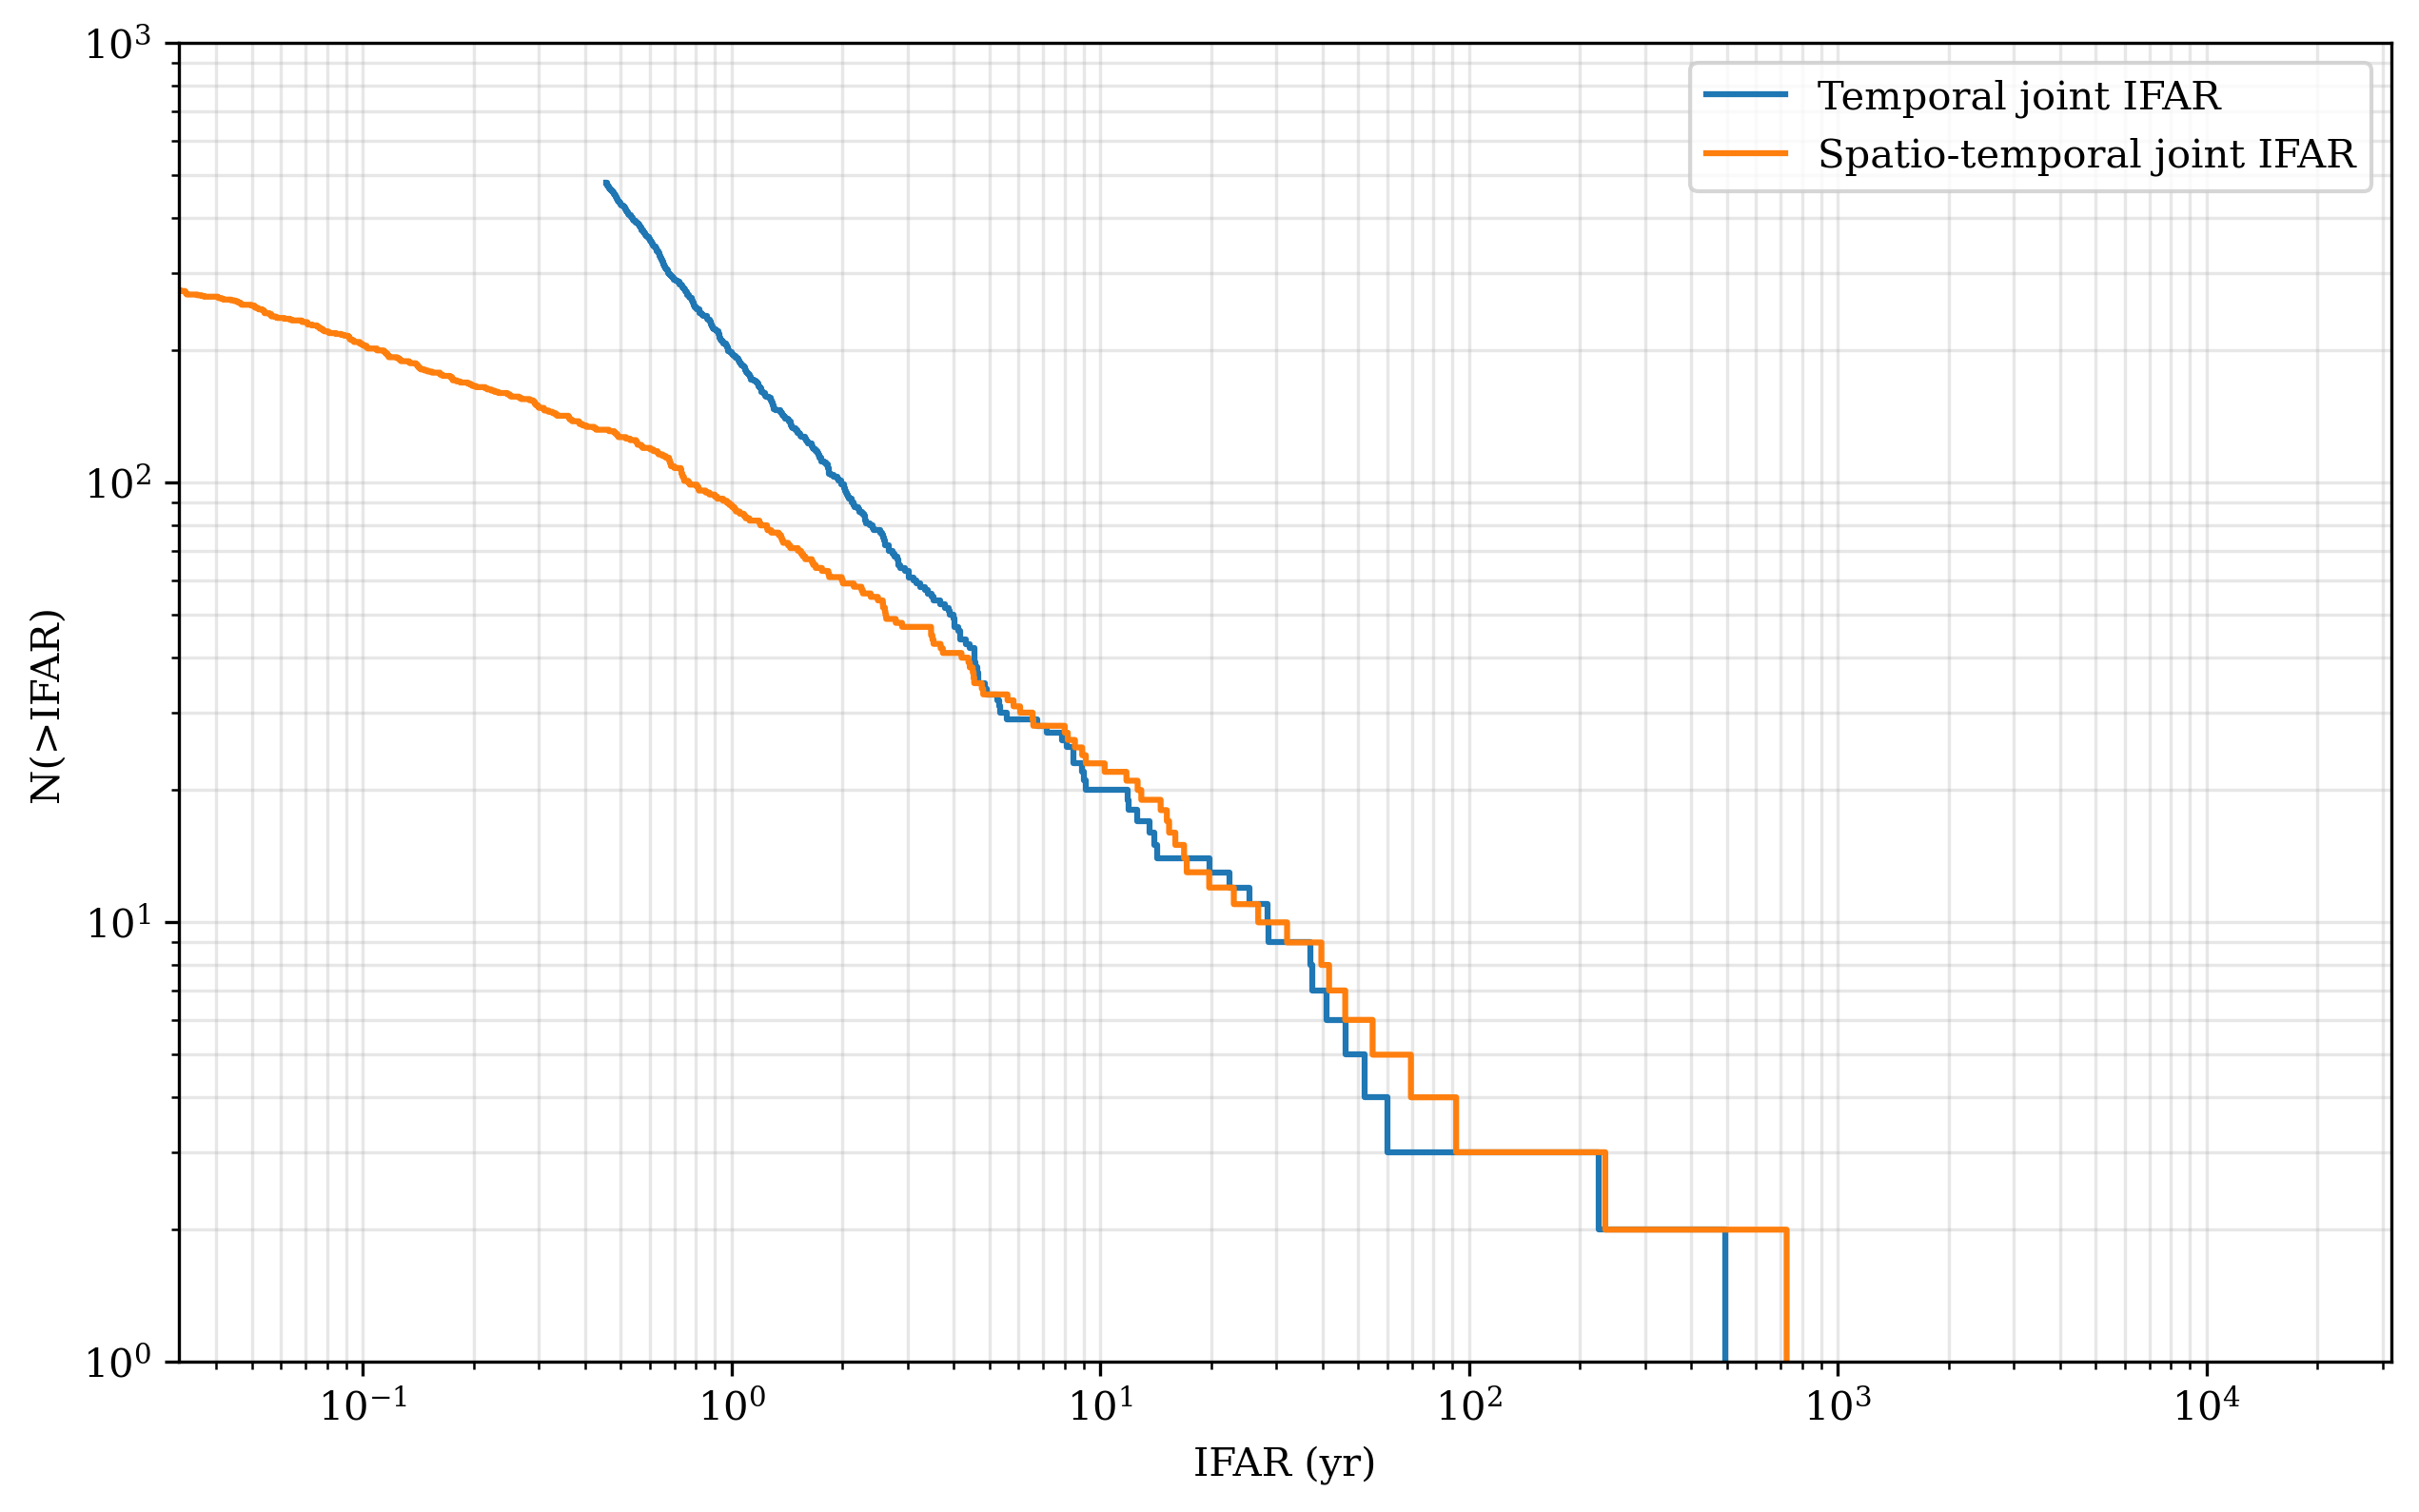

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from plot_config import setup_matplotlib_style

import matplotlib.pyplot as plt

# Configure matplotlib with high-quality settings
setup_matplotlib_style()

from scipy.stats import poisson
from scipy.stats import norm

# Convert FAR to IFAR (Inverse False Alarm Rate)
temp_ifar = 1 / np.array(temp_far)
sp_temp_ifar = 1 / np.array(sp_temp_far)

# Sort IFAR values
temp_ifar_sorted = np.sort(temp_ifar)
sp_temp_ifar_sorted = np.sort(sp_temp_ifar)

# Calculate N(>IFAR) - number of events with IFAR greater than each value
temp_n = np.arange(len(temp_ifar_sorted), 0, -1)
sp_n = np.arange(len(sp_temp_ifar_sorted), 0, -1)

temp_ifar_sorted_yr = temp_ifar_sorted / (365.25 * 24 * 3600)
sp_temp_ifar_sorted_yr = sp_temp_ifar_sorted / (365.25 * 24 * 3600)

plt.figure(figsize=(10, 6))
# Update the plot calls to use years
plt.clf()
plt.plot(temp_ifar_sorted_yr, temp_n, label='Temporal joint IFAR', drawstyle='steps-post')
plt.plot(sp_temp_ifar_sorted_yr, sp_n, label='Spatio-temporal joint IFAR', drawstyle='steps-post')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('IFAR (yr)')
plt.ylabel('N(>IFAR)')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.xlim(1e6 / (365.25 * 24 * 3600), 1e12 / (365.25 * 24 * 3600))
plt.ylim(1, 1e3)
plt.show()

Let's compare with the theoretical line we expect from a pure randomly generated coincidences 

<Figure size 4800x1800 with 0 Axes>

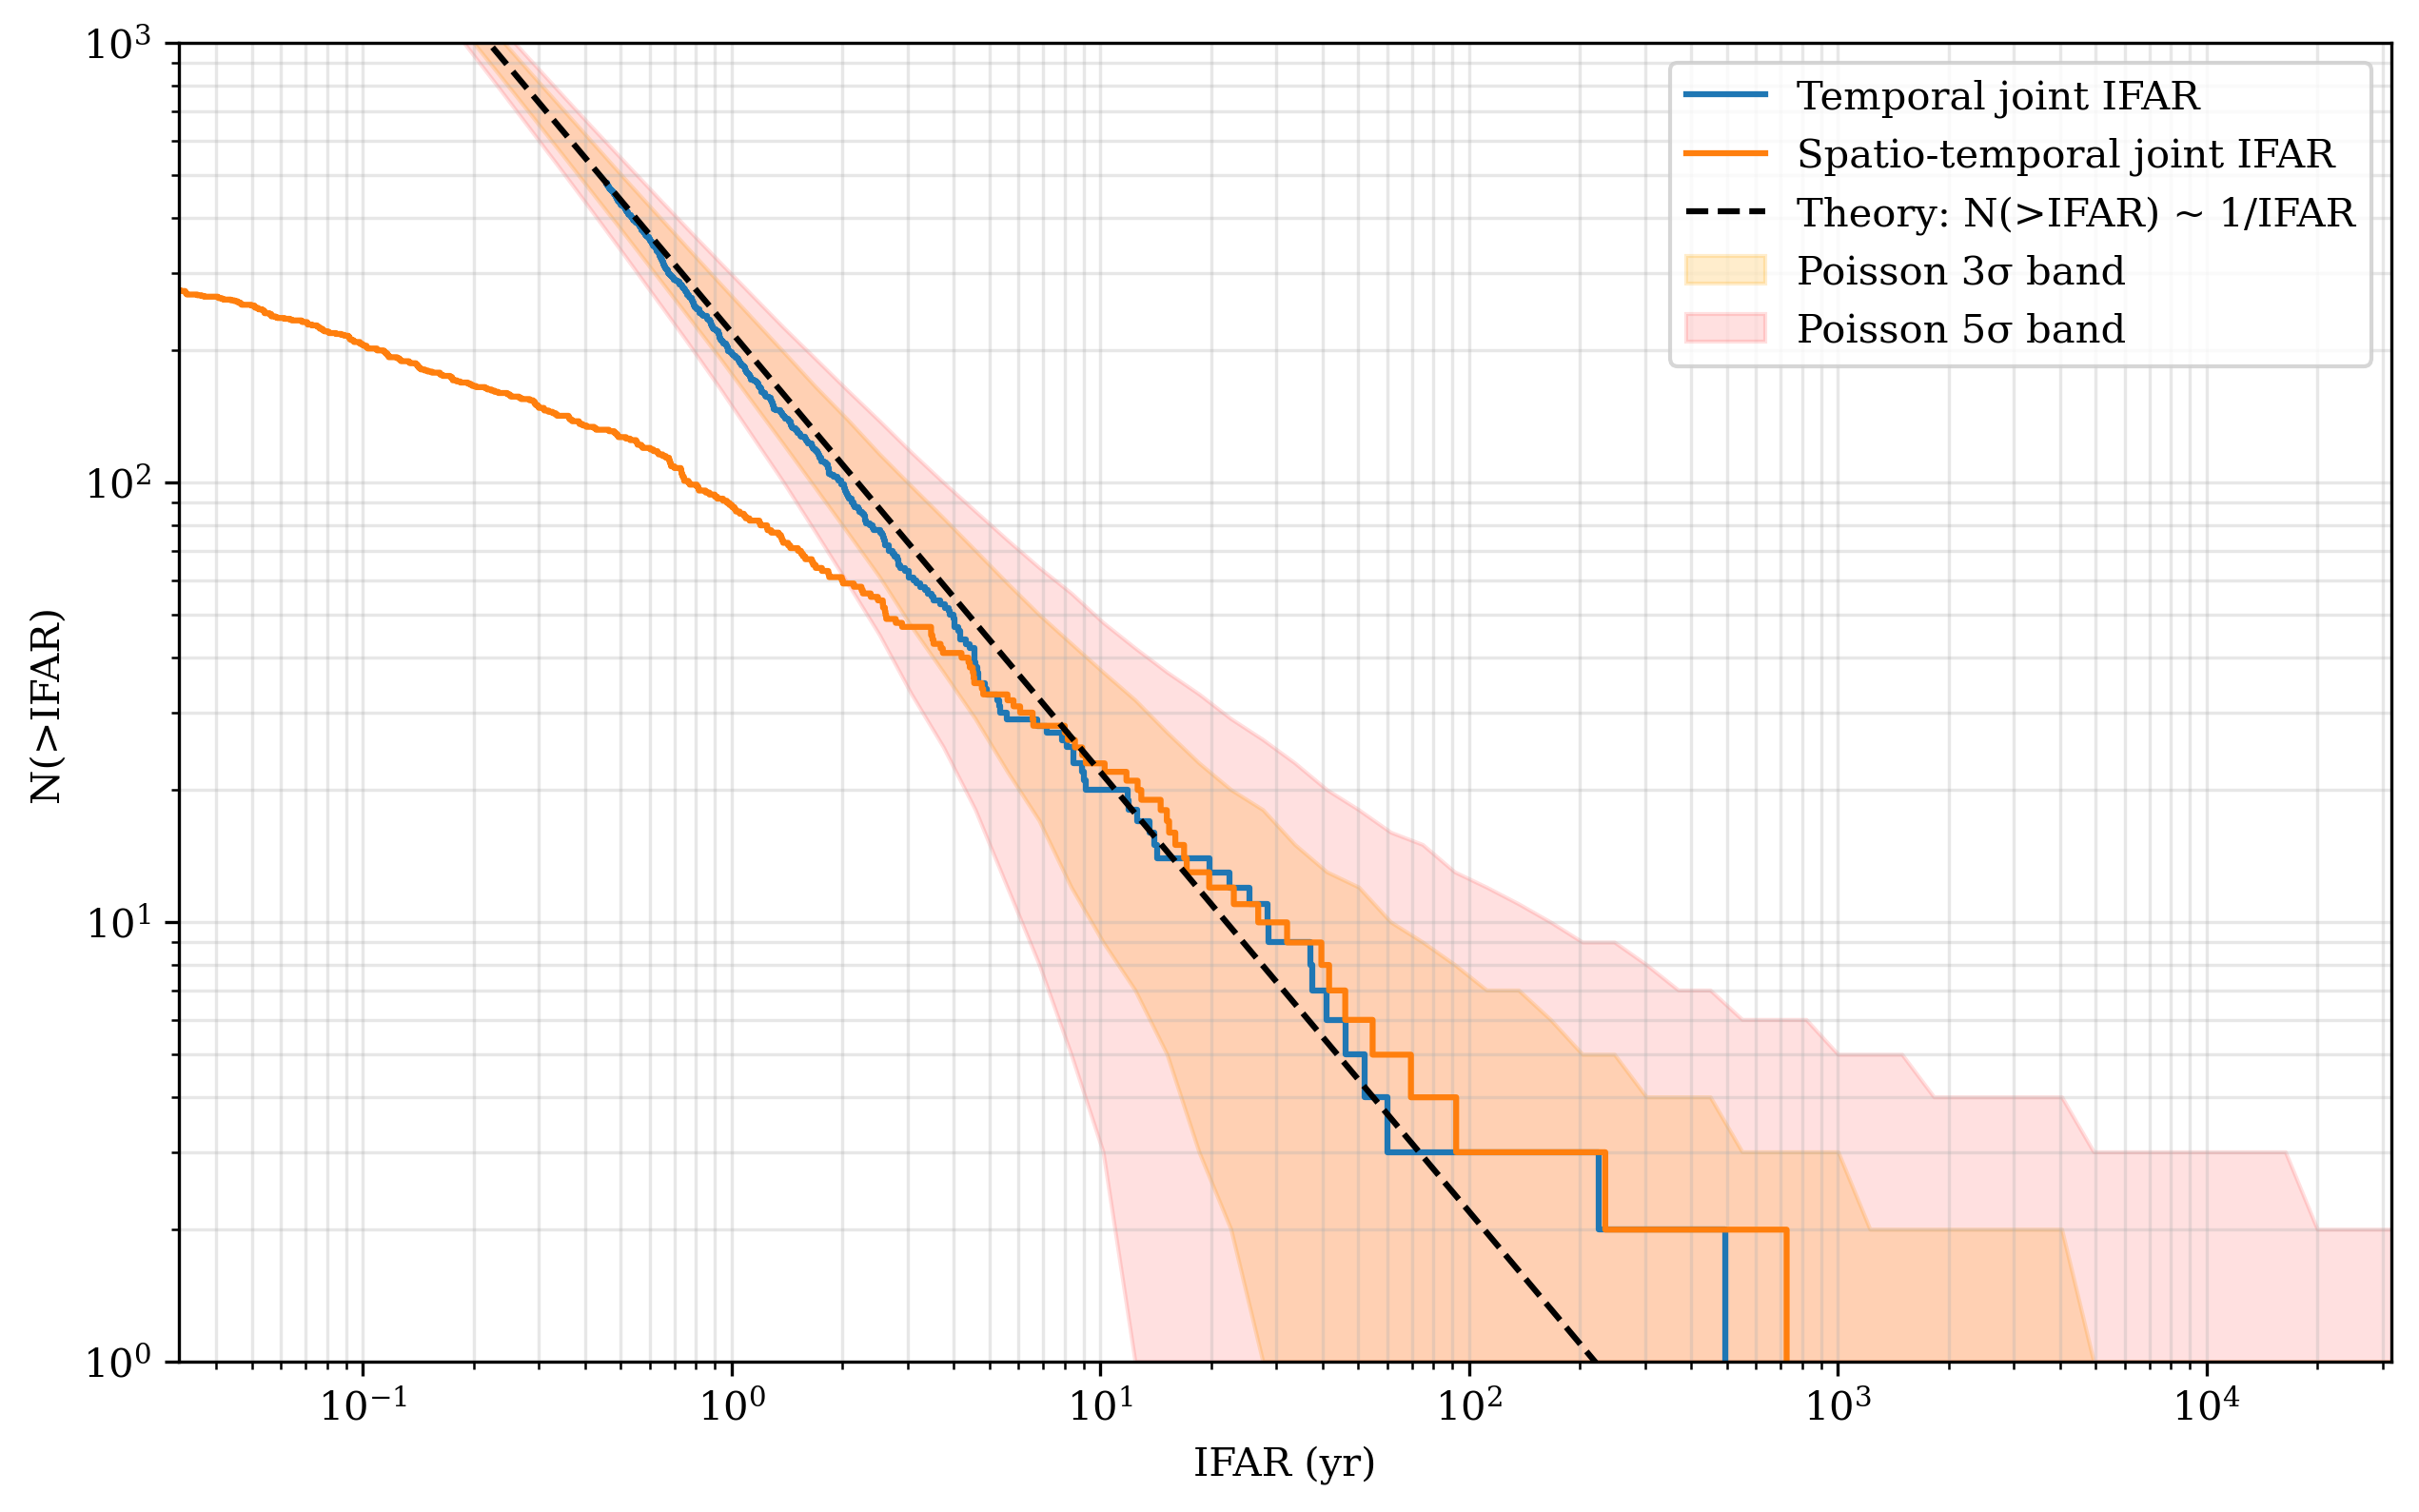

In [149]:

# Theoretical line: N(>IFAR) = A / IFAR (set A from sample size and min IFAR)
A = len(df) / (30 * 2  / 3600 / 24 * 1e-4)

# Extend IFAR theory range to cover larger values
ifar_min = min(temp_ifar_sorted.min(), sp_temp_ifar_sorted.min())
ifar_max_obs = max(temp_ifar_sorted.max(), sp_temp_ifar_sorted.max())
ifar_max = ifar_max_obs * 1000.0
ifar_theory = np.logspace(np.log10(ifar_min), np.log10(ifar_max), 400)
n_theory = A / ifar_theory

# Exact Poisson central intervals for 3σ and 5σ
def poisson_band(mu, sigma):
    # Compute two-sided tail probabilities for k-sigma using Gaussian
    lower_p = norm.cdf(-sigma)
    upper_p = norm.cdf(sigma)
    lower = poisson.ppf(lower_p, mu)
    upper = poisson.ppf(upper_p, mu)
    lower = np.maximum(lower.astype(float), 1.0)
    upper = upper.astype(float)
    return lower, upper

lower3, upper3 = poisson_band(n_theory, 3)
lower5, upper5 = poisson_band(n_theory, 5)

# Convert IFAR from seconds to years for x-axis
ifar_theory_yr = ifar_theory / (365.25 * 24 * 3600)
temp_ifar_sorted_yr = temp_ifar_sorted / (365.25 * 24 * 3600)
sp_temp_ifar_sorted_yr = sp_temp_ifar_sorted / (365.25 * 24 * 3600)

plt.plot(ifar_theory_yr, n_theory, 'k--', label='Theory: N(>IFAR) ~ 1/IFAR')
plt.fill_between(ifar_theory_yr, lower3, upper3, color='orange', alpha=0.2, label='Poisson 3σ band')
plt.fill_between(ifar_theory_yr, lower5, upper5, color='red', alpha=0.12, label='Poisson 5σ band')

# Update the plot calls to use years
plt.clf()
plt.figure(figsize=(10, 6))
plt.plot(temp_ifar_sorted_yr, temp_n, label='Temporal joint IFAR', drawstyle='steps-post')
plt.plot(sp_temp_ifar_sorted_yr, sp_n, label='Spatio-temporal joint IFAR', drawstyle='steps-post')
plt.plot(ifar_theory_yr, n_theory, 'k--', label='Theory: N(>IFAR) ~ 1/IFAR')
plt.fill_between(ifar_theory_yr, lower3, upper3, color='orange', alpha=0.2, label='Poisson 3σ band')
plt.fill_between(ifar_theory_yr, lower5, upper5, color='red', alpha=0.12, label='Poisson 5σ band')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('IFAR (yr)')
plt.ylabel('N(>IFAR)')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.xlim(1e6 / (365.25 * 24 * 3600), 1e12 / (365.25 * 24 * 3600))
plt.ylim(1, 1e3)
plt.show()

Question: What should be the value of the integral overlap $I_{\Omega}$ to have the highest ranked candidate outside at least the 3 sigma confidence region?

:::{note}
The width of the confidence interval of the theoretical IFAR curve scales with $1/\sqrt{N}$, being $N$ the number of couples GRB-GW for which the computed the joint FAR so far. That's why the more background we accumulate, the more we observe, the higher is the significance of a joint candidate with a given joint FAR
:::